In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import zipfile
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# each image is an array of individual img arrays :o
import pathlib
full_path = os.path.abspath("drive/Shareddrives/CSC_422_Project/animals2.zip")
data_dir = tf.keras.utils.get_file('animals2.zip', f'file://{full_path}', extract=True)


data_dir = pathlib.Path(data_dir).with_suffix('')

parent_dir = pathlib.Path(data_dir).parent
data_dir = parent_dir / 'animals'
print(data_dir)


image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

106510318/106510318 [==============================] - 1s 0us/step
/root/.keras/datasets/animals
5419


In [4]:
batch_size = 32
img_height, img_width = 128, 128


train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.15, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

print(train_ds)
class_names = train_ds.class_names
print(class_names)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5419 files belonging to 90 classes.
Using 812 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark',

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
normalization_layer = layers.Rescaling(1./255)

In [7]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
normalized_ds = datasets.ImageFolder(
            data_dir,
            transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ]))

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.


In [8]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
import numpy as np
from skimage import io
from skimage.util import view_as_windows

img = io.imread('image_name.png')
 # dividing by sqrt(16) = 4 splits image into 16 parts
num_windows = 16
conv_size = num_windows**0.5
window_shape = (img_height / conv_size, img_width / conv_size)

windows = view_as_windows(img, window_shape)
n_windows = np.prod(windows.shape[:2])
n_pixels = np.prod(windows.shape[2:])

x_test = windows.reshape(n_windows, n_pixels)

clf.apply(x_test)

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [12]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 29s 989ms/step - loss: 4.5090 - accuracy: 0.0135 - val_loss: 4.4923 - val_accuracy: 0.0394
Epoch 2/10
26/26 [==============================] - 34s 1s/step - loss: 4.4350 - accuracy: 0.0431 - val_loss: 4.3560 - val_accuracy: 0.0720
Epoch 3/10
26/26 [==============================] - 32s 1s/step - loss: 3.9906 - accuracy: 0.1219 - val_loss: 3.7777 - val_accuracy: 0.2074
Epoch 4/10
26/26 [==============================] - 23s 918ms/step - loss: 2.6028 - accuracy: 0.4002 - val_loss: 3.3222 - val_accuracy: 0.4062
Epoch 5/10
26/26 [==============================] - 20s 799ms/step - loss: 0.9085 - accuracy: 0.7697 - val_loss: 3.7931 - val_accuracy: 0.5138
Epoch 6/10
26/26 [==============================] - 22s 845ms/step - loss: 0.2082 - accuracy: 0.9532 - val_loss: 4.7876 - val_accuracy: 0.5385
Epoch 7/10
26/26 [==============================] - 22s 865ms/step - loss: 0.0596 - accuracy: 0.9852 - val_loss: 5.3609 - val_accuracy: 0.5415
Epoch

14313/14313 [==============================] - 0s 0us/step
/root/.keras/datasets/animals


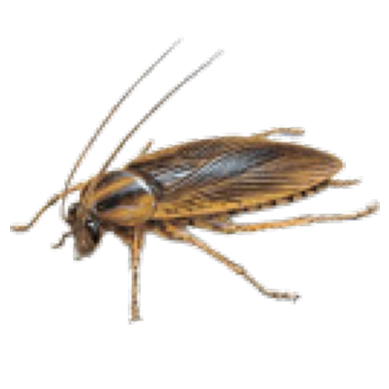

In [13]:
test_path = '/content/drive/Shareddrives/CSC_422_Project/animals/cockroach/0aea14ad46.png'




full_path = os.path.abspath(test_path)
data_dir = tf.keras.utils.get_file('0aea14ad46.png', f'file://{full_path}', extract=True)


data_dir = pathlib.Path(data_dir).with_suffix('')

parent_dir = pathlib.Path(data_dir).parent
data_dir = parent_dir / 'animals'

print(data_dir)
img = tf.keras.utils.get_file('0aea14ad46.png', origin=data_dir)

# from PIL import Image
# image = Image.open(img)
# image.show()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img2 = mpimg.imread(img) #Replace "image.jpg" with the path of your image
plt.imshow(img2)
plt.axis('off')
plt.show()

In [14]:

img2 = tf.keras.utils.load_img(
    img, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image is most likely a(n) {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 196ms/step
This image is most likely a(n) reindeer with a 99.72 percent confidence.
